### CS IDs: l9o1b, s8s1b
This submission contains responses for the second phase of problem set 5, in which we implement and test the methods alluded to and worked out in the previous part. For those interested, we constructed our write-up in a Jupyter Notebook using the Matlab Kernel, with some additonal functions stored as files.

In [95]:
%plot inline

In [96]:
clear variables; close all; clc;

## Set-up
We'll first run some preliminary code to get our starting parameters set.

In [161]:
% Discretization parameters
nx = 81;
ny = 81;
dt = 0.025;
dx = 1/(nx-1);
dy = 1/(ny-1);

% Time interval
t_0 = 0;
tf = 0.25;

% Problem parameters
D = 0.05;
kindergarten = [0.5, 0.5];
W = 1;
theta = pi/2;
a1 = 2;
a2 = 1;
s1 = 100;
s2 = 150;

% Set up arrays for later
x = 0:dx:1;
y = 0:dy:1;
t = 0:dt:tf;
nt = length(t);

## Create u
We'll create a matrix whose columns represent the flattned grid of pollution values at a number of different time steps. The first column is defined using the initial condition, and the rest are zeros.

In [162]:
% the first dimension of u is the flattened spatial dimension,
% and the second dimension is time
u = zeros(ny*nx, nt);

boundaries = [1:ny 1:ny:ny*nx ny:ny:ny*nx nx*(ny-1)+1:nx*ny];
% (above) might be less confusing to use the G function for this...

%% Initial condition
u0 = a1*exp(-s1*bsxfun(@plus, (x-0.25).^2, (y'-0.25).^2)) + ...
     a2*exp(-s2*bsxfun(@plus, (x-0.65).^2, (y'-0.4).^2));
u(:,1) = u0(:); % flatten
u(boundaries,1) = 0; % set initial condition at boundaries to 0

## Initial plot
This will give us a look at the system before we let any diffusion-convection take place.

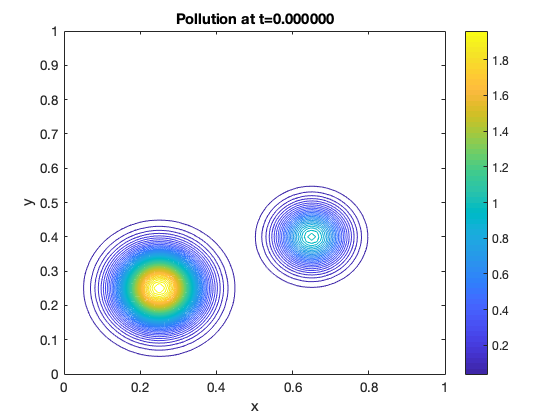

In [163]:
uplot = reshape(u, [ny, nx, nt]);

num_contours = 50;

figure;
contour(x, y, uplot(:,:,1), num_contours);
colorbar;
title(sprintf('Pollution at t=%f', 0));
xlabel('x');
ylabel('y');

## Creating the 'A' Matrix
Next, we use the provided code to generate the matrix A, which encodes our update rule for backward Euler integration. Since so many of the matrix entries are zero, we will use the spy() command to get a better idea of the sparsity pattern, and relate it back to our model.

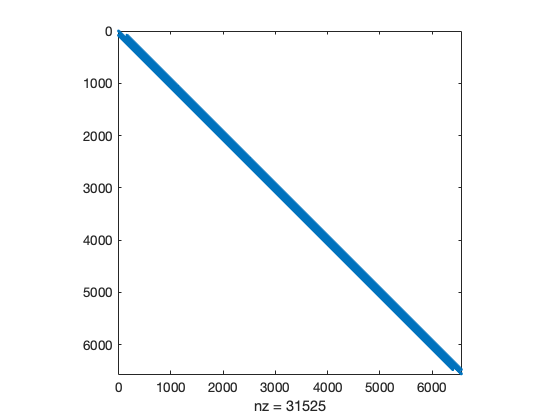

In [164]:
A = createA(D, W, theta, nx, ny, dx, dy, dt);
spy(A) % generate sparsity visualization

The plot above makes it very hard to see the actual pattern, so we can zoom in to a region near the middle:

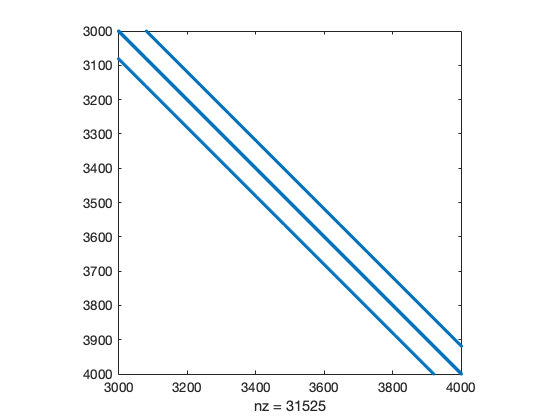

In [165]:
spy(A)
xlim([3000 4000])
ylim([3000 4000])

This is alright, but we can do better...

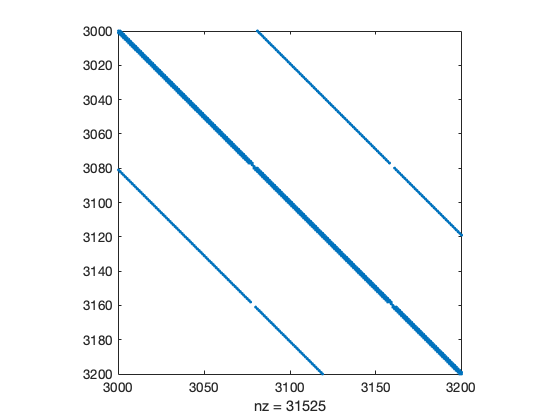

In [166]:
spy(A)
xlim([3000 3200])
ylim([3000 3200])

We can now start to see the true structure of the matrix entries. Let's zoom in one more time.

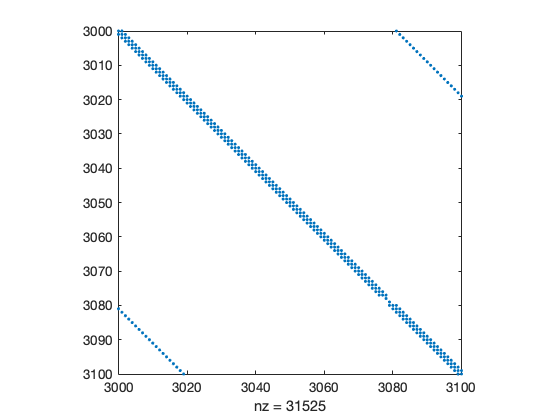

In [167]:
spy(A)
xlim([3000 3100])
ylim([3000 3100])

This final figure lets us see the precise layout of the nonzero entries, which closely reflects the mathematical definitions we had in the previous part of the assignment. In particular, we can see the (roughly) 5 nonzero entries per row that correspond to the 5 evaluations of the pollution function used to compute the discretized derivative at each point. The three entries in the center ribbon correspond to the center and vertically-adjacent points (since we use column-major order) and the two entries bordering these (~81 entries away) are the horizontal neighbours. The gaps in the center line indicate identity rows, which correspond to points on the border of our grid.

## Solving the PDE Numerically
Next we will solve the PDE over the given time interval using the backward Euler method. For the purposes of reusability, let us define a function that updates our u vectors, using a given A and number of time steps.

In [ ]:
%%file beuler.m
function u = beuler(A, nt, u)
    for i = 2:nt
            u(:,i) = A \ u(:, i-1);
    end
end

and a function to plot the pollution for a given time step:

In [ ]:
%%file makeplot.m
function out = makeplot(t, dt, ny, nx, nt, x, y, u)
    uplot = reshape(u, [ny, nx, nt]);
    num_contours = 50;
    figure;
    contour(x, y, uplot(:,:,t), num_contours);
    colorbar;
    title(sprintf('Pollution at t=%f', (t - 1)*dt));
    xlabel('x');
    ylabel('y');
    out = 1;
end

Next, we'll run the backward Euler integration and plot at three time steps, t = 0, 0.125, 0.25. Note: this code takes about 30 seconds to run, which is accurately described as "painfully slow"


update_time =

   27.5064



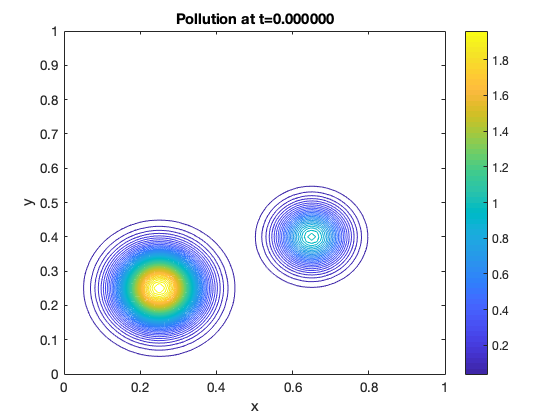

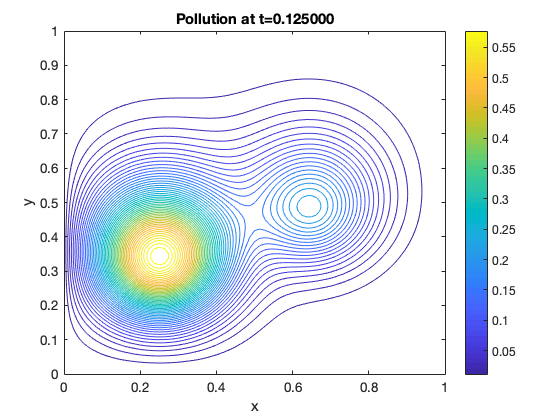

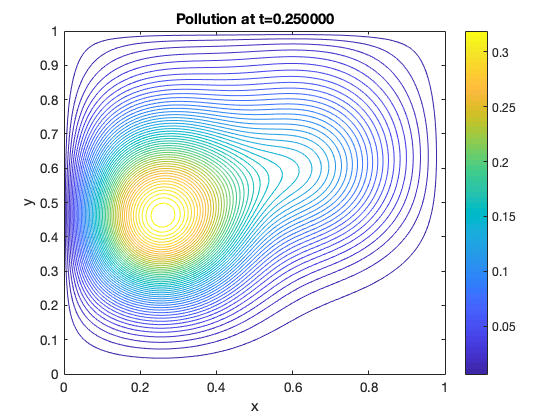

In [176]:
tic
u = beuler(A, nt, u);
update_time = toc
makeplot(11, dt, ny, nx, nt, x, y, u);
makeplot(6, dt, ny, nx, nt, x, y, u);
makeplot(1, dt, ny, nx, nt, x, y, u);
% had to invert these to get plots in right order (idk why)

We can improve the speed of this code by using a version of A understood to be a sparse matrix. By using the sparse() function, we allow Matlab to avoid needless computations involving zeros.

In [177]:
tic
% perform the same integration using the sparse version of A
beuler(sparse(A), nt, u);
update_time_sparse = toc


update_time_sparse =

    0.2588



In [178]:
speedup = update_time / update_time_sparse


speedup =

  106.3034



## Solving Speedily (part h)
We can now carry out the same integration as above but with a much smaller step size, and in a reasonable amount of time. We do this with dt=0.005, and plot the beginning, middle, and end time steps (as before).


dt =

    0.0050



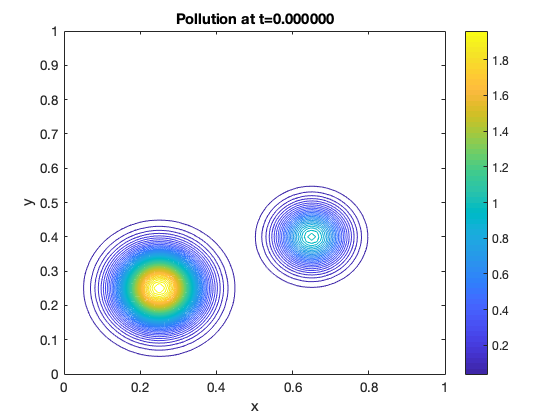

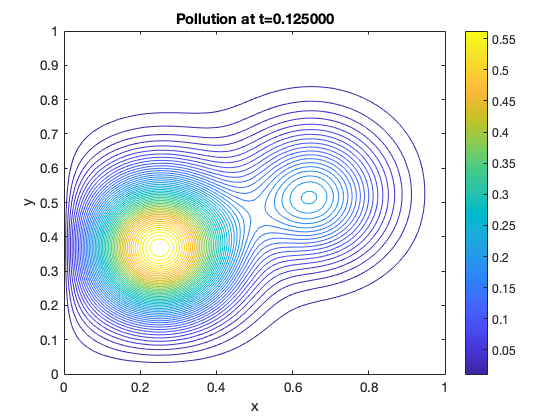

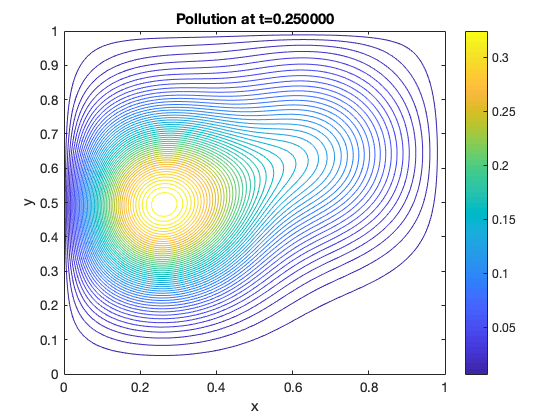

In [179]:
dt = 0.005  % set t step-size to new value
t = 0:dt:tf;   % update the parameters that depend on dt
nt = length(t);

A = createA(D, W, theta, nx, ny, dx, dy, dt);  % create the new matrix

u = beuler(sparse(A), nt, u);
makeplot(51, dt, ny, nx, nt, x, y, u);
makeplot(26, dt, ny, nx, nt, x, y, u);
makeplot(1, dt, ny, nx, nt, x, y, u);

We see that we have produced seemingly equivalent (although likely more accurate) plots in a fraction of the time.

## Estimating Total Pollution
We now use the approximation of u computed in the previous parts to integrate pollution over the time interval

In [180]:
G = @(i,j) i + (j-1)*ny; 
u_idx = G(41,41)   % compute the index in u of the kindergarten position


u_idx =

        3281



In [181]:
Y = u(u_idx, :);   % get the appropriate row of the u matrix
X = t;             % t steps

K = trapz(X,Y)     % integrate with composite trapezoids


K =

    0.0340



## Monte Carlo
Below we define a function that generates samples for our W, theta, a1, and a2 values from their appropriate distributions, and uses them to perform the same integration as above. 

In [ ]:
%%file eval_k_monte.m
function K = eval_k_monte(D, t, dt, dx, dy, nx, ny, x, y, nt, ...
                s1, s2, mean_a1, mean_a2)

    % get the u row
    G = @(i,j) i + (j-1)*ny; 
    u_idx = G(41,41);

    % sample
    W = wblrnd303(2,2);
    theta = rand() * (2*pi);
    a1 = exprnd(mean_a1);
    a2 = exprnd(mean_a2);
    
    %% Initial condition
    u0 = a1*exp(-s1*bsxfun(@plus, (x-0.25).^2, (y'-0.25).^2)) + ...
        a2*exp(-s2*bsxfun(@plus, (x-0.65).^2, (y'-0.4).^2));
    u(:,1) = u0(:); % flatten
    
    % integrate
    
    A = createA(D, W, theta, nx, ny, dx, dy, dt);
    u = beuler(sparse(A), nt, u);
    Y = u(u_idx, :);
    X = t;
    
    K = trapz(X,Y);
    
end

Using 100 sample sets, we compute an approximate expection for K

In [187]:
n = 100;
sum_special_k = 0;
for i = 1:n
    k = eval_k_monte(D, t, dt, dx, dy, nx, ny, x, y, nt, s1, s2, a1, a2);
    sum_special_k = sum_special_k + k;
end
EK = sum_special_k / n


EK =

    0.0199



## Remarks on Error
To conclude, we will address the sources of error in this model falling into three categories: truncation error, roundoff error, and other errors that don't fall cleanly into either of these to categories but that derive from the methods used to model the system.

Most notable is the truncation error encoded in our discretization of the 2-dimensional space into a finite grid. In using a discrete approximation for the spacial derivatives, we essentially chop of terms of the taylor expansions of the pollution function in order to approximate its derivatives with second-order accuracy. Second order accuracy is respectable, but as we saw, using smaller step-sizes can lead to issues with efficiency and implementation.

In addressing roundoff error, we observe that we make many kinds of finite-precision arithmetic operations in this procedure, and that this kind of error is in many ways unavoidable. Roundoff error could become a more pronounced problem if the pollution in the system was preserved i.e. the pollution was not eliminated at the boundary. In this case, roundoff error would have a large effect if we were trying to final the stable solution of an IVP as time tends to infinity. Roundoff error leads to propogated error over time, so for the small amount of calculations we are doing, it seems to be acceptable, however for longer calculations of the system, roundoff error will have more of an effect.

There are many other sources of error that aren't particulary those described in chapter 1, but instead manifested due to our modeling choices. One source of error we'd like to acknoweledge is the boundary condition 'depreciation'. Over time, the loss of pollution in the system is most heavily effected by the elimination of pollution when it reaches the border, which causes the rate of diffusion to be higher near the border than in a 'real life' scenario.

Another source of error is the error associated with Monte-Carlo Integration. MC gives us a good idea of what the true value might be, but it isn't all too exact, especially with only running 100 iterations like we are. To analyze the Monte-Carle scheme we are using, we ran the MC integration 10 times and found the expectation to be 0.0192 and the standard deviation to be 0.0022. Our values were ranging from 0.0165 to 0.0221, and with an standard deviation of 0.0022, we weren't incredibly confident to how close the MC integration is to real value, but it gives us a good ballpark of where the true expectation might be.

In [191]:
MC = [0.0221; 0.0166; 0.0210; 0.0207; 0.017; ...
        0.0205; 0.0179; 0.0176; 0.0165; 0.0218];

std_MC = std(MC)
mean_MC = mean(MC)


std_MC =

    0.0022


mean_MC =

    0.0192

